In [20]:
import sys
sys.path.insert(0, '/Users/alex/Documents/noise/universal_inverse_problem/code')

In [21]:
import argparse

import torch
from network import BF_CNN

parser = argparse.ArgumentParser(description='BF_CNN_gray')
parser.add_argument('--dir_name', default= './')
parser.add_argument('--kernel_size', default= 3)
parser.add_argument('--padding', default= 1)
parser.add_argument('--num_kernels', default= 64)
parser.add_argument('--num_layers', default= 20)
parser.add_argument('--num_channels', default= 1)

args = parser.parse_args('')

model = BF_CNN(args)
learned_params = torch.load(
    '/Users/alex/Documents/noise/universal_inverse_problem/denoisers/BF_CNN/BSD400_gray/noise_range_0to100/model.pt',
    map_location='cpu')
model.load_state_dict(learned_params)

model_mse = BF_CNN(args)
learned_params = torch.load(
    '/Users/alex/Documents/noise/mse-99-157000-checkpoint.pth',
    map_location='cpu')
model_mse.load_state_dict(learned_params)

model_nlpd = BF_CNN(args)
learned_params = torch.load(
    '/Users/alex/Documents/noise/nlpd-99-157000-checkpoint.pth',
    map_location='cpu')
model_nlpd.load_state_dict(learned_params)

model_dists = BF_CNN(args)
learned_params = torch.load(
    '/Users/alex/Documents/noise/dists-84-265000-checkpoint.pth',
    map_location='cpu')
model_dists.load_state_dict(learned_params)

_ = model.eval()
_ = model_mse.eval()
_ = model_nlpd.eval()
_ = model_dists.eval()

In [23]:
# Test denoising ability
import torchvision
from torchvision.transforms import transforms
from skimage.color import rgb2gray

import numpy as np
from skimage import io
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

from glob import glob

from tqdm import tqdm 

dataset = []
for f in glob('/Users/alex/Documents/noise/Kodak-Lossless-True-Color-Image-Suite/PhotoCD_PCD0992/*.png'):
  dataset.append(rgb2gray(io.imread(f)).astype(np.float32))

noisy_images = []
denoised = []
denoised_mse = []
denoised_nlpd = []
denoised_dists = []

for im in tqdm(dataset[0:3]):
  data = torch.from_numpy(im).unsqueeze(0).unsqueeze(0)
  noise_image = data + torch.normal(mean=torch.zeros_like(data)+0.1, std=0.1)
  noisy_images.append(noise_image.squeeze().numpy())
  denoised.append((noise_image-model(noise_image)).squeeze().detach().numpy())
  denoised_mse.append((noise_image-model_mse(noise_image)).squeeze().detach().numpy())
  denoised_nlpd.append((noise_image-model_nlpd(noise_image)).squeeze().detach().numpy())
  denoised_dists.append((noise_image-model_dists(noise_image)).squeeze().detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.74s/it]


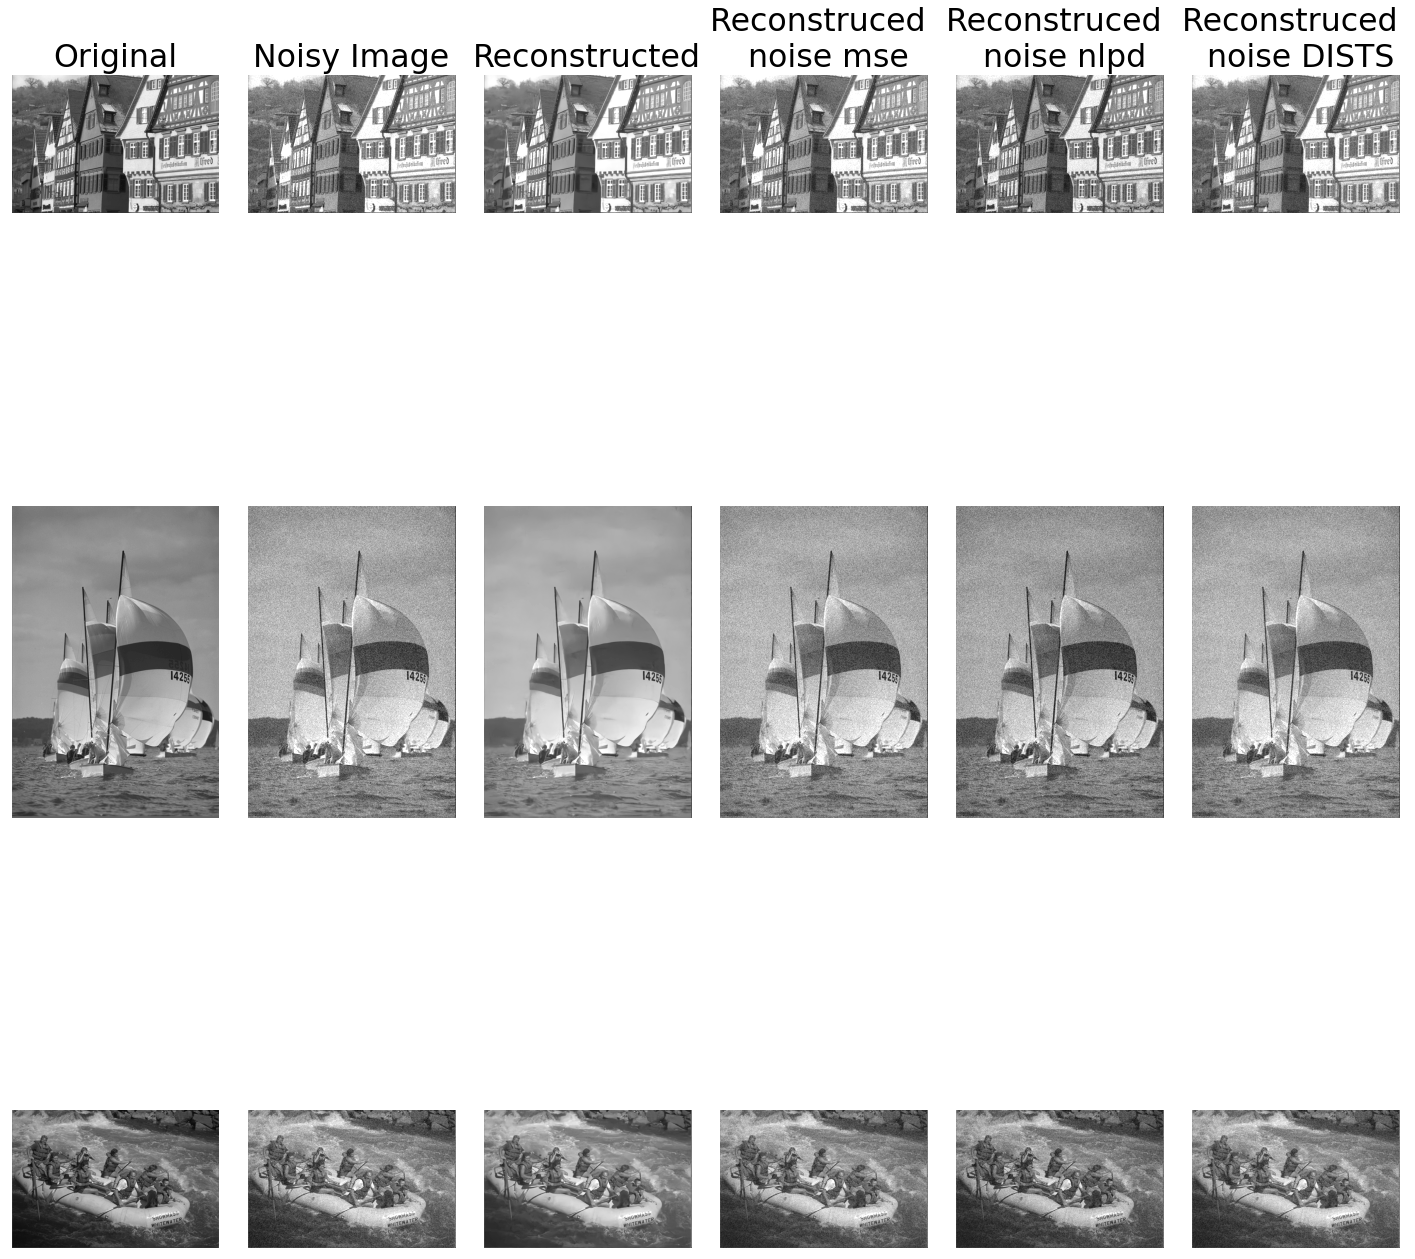

In [24]:
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(3, 6, figsize=(20, 25))

axs[0][0].imshow(dataset[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][0].imshow(dataset[1],  cmap='gray', vmin=0.0, vmax=1.0)
axs[2][0].imshow(dataset[2],  cmap='gray', vmin=0.0, vmax=1.0)
    
axs[0][1].imshow(noisy_images[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][1].imshow(noisy_images[1], cmap='gray', vmin=0.0, vmax=1.0)
axs[2][1].imshow(noisy_images[2], cmap='gray', vmin=0.0, vmax=1.0)

axs[0][2].imshow(denoised[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][2].imshow(denoised[1], cmap='gray', vmin=0.0, vmax=1.0)
axs[2][2].imshow(denoised[2], cmap='gray', vmin=0.0, vmax=1.0)

axs[0][3].imshow(denoised_mse[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][3].imshow(denoised_mse[1], cmap='gray', vmin=0.0, vmax=1.0)
axs[2][3].imshow(denoised_mse[2], cmap='gray', vmin=0.0, vmax=1.0)

axs[0][4].imshow(denoised_nlpd[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][4].imshow(denoised_nlpd[1], cmap='gray', vmin=0.0, vmax=1.0)
axs[2][4].imshow(denoised_nlpd[2], cmap='gray', vmin=0.0, vmax=1.0)

axs[0][5].imshow(denoised_dists[0], cmap='gray', vmin=0.0, vmax=1.0)
axs[1][5].imshow(denoised_dists[1], cmap='gray', vmin=0.0, vmax=1.0)
axs[2][5].imshow(denoised_dists[2], cmap='gray', vmin=0.0, vmax=1.0)

axs[0][0].set_title('Original')
axs[0][1].set_title('Noisy Image')
axs[0][2].set_title('Reconstructed')
axs[0][3].set_title('Reconstruced \n noise mse')
axs[0][4].set_title('Reconstruced \n noise nlpd')
axs[0][5].set_title('Reconstruced \n noise DISTS')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('recon.png', bbox_inches='tight')

In [25]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def ssim(clean, noisy, normalized=True):
    """Use skimage.meamsure.compare_ssim to calculate SSIM
    Args:
        clean (Tensor): (B, 1, H, W)
        noisy (Tensor): (B, 1, H, W)
        normalized (bool): If True, the range of tensors are [0., 1.] else [0, 255]
    Returns:
        SSIM per image: (B, )
    """
    if normalized:
        clean = clean.mul(255).clamp(0, 255)
        noisy = noisy.mul(255).clamp(0, 255)

    clean = clean.cpu().detach().numpy().astype(np.float32)
    noisy = noisy.cpu().detach().numpy().astype(np.float32)
    return np.array([structural_similarity(c[0], n[0], data_range=255) for c, n in zip(clean, noisy)]).mean()


def psnr(clean, noisy, normalized=True):
    """Use skimage.meamsure.compare_ssim to calculate SSIM
    Args:
        clean (Tensor): (B, 1, H, W)
        noisy (Tensor): (B, 1, H, W)
        normalized (bool): If True, the range of tensors are [0., 1.]
            else [0, 255]
    Returns:
        SSIM per image: (B, )
    """
    if normalized:
        clean = clean.mul(255).clamp(0, 255)
        noisy = noisy.mul(255).clamp(0, 255)

    clean = clean.cpu().detach().numpy().astype(np.float32)
    noisy = noisy.cpu().detach().numpy().astype(np.float32)
    return np.array([peak_signal_noise_ratio(c[0], n[0], data_range=255) for c, n in zip(clean, noisy)]).mean()

In [80]:
model_metrics = []
model_mse_metrics = []
model_nlpd_metrics = []
model_dists_metrics = []

psnr_inputs = []
ssim_inputs = []
noise_levels = np.arange(10, 110, 10)/255.
print(noise_levels)

for std in tqdm(noise_levels):
    pavg1, pavg2, pavg3, pavg4 = [], [], [], []
    mavg1, mavg2, mavg3, mavg4 = [], [], [], []
    psnr_input = []
    ssim_input = []
    for im in dataset:
        data = torch.from_numpy(im).unsqueeze(0).unsqueeze(0)
        noise = std/255. * torch.rand(1) + 0. # max_noise=55, min_noise=0.
        noise_image = data + torch.normal(mean=torch.zeros_like(data), std=std)
        denoised = (noise_image-model(noise_image)).detach()
        denoised_mse = (noise_image-model_mse(noise_image)).detach()
        denoised_nlpd = (noise_image-model_nlpd(noise_image)).detach()
        denoised_dists = (noise_image-model_dists(noise_image)).detach()
        
        psnr_input.append(psnr(data, noise_image))
        ssim_input.append(ssim(data, noise_image))
        pavg1.append(psnr(data, denoised))
        pavg2.append(psnr(data, denoised_mse))
        pavg3.append(psnr(data, denoised_nlpd))
        pavg4.append(psnr(data, denoised_dists))
        mavg1.append(ssim(data, denoised))
        mavg2.append(ssim(data, denoised_mse))
        mavg3.append(ssim(data, denoised_nlpd))
        mavg4.append(ssim(data, denoised_dists))
    model_metrics.append((np.mean(pavg1), np.mean(mavg1)))
    model_mse_metrics.append((np.mean(pavg2), np.mean(mavg2)))
    model_nlpd_metrics.append((np.mean(pavg3), np.mean(mavg3)))
    model_dists_metrics.append((np.mean(pavg4), np.mean(mavg4)))
    psnr_inputs.append(np.mean(psnr_input))
    ssim_inputs.append(np.mean(ssim_input))

[0.03921569 0.07843137 0.11764706 0.15686275 0.19607843 0.23529412
 0.2745098  0.31372549 0.35294118 0.39215686]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [27:19<00:00, 163.99s/it]


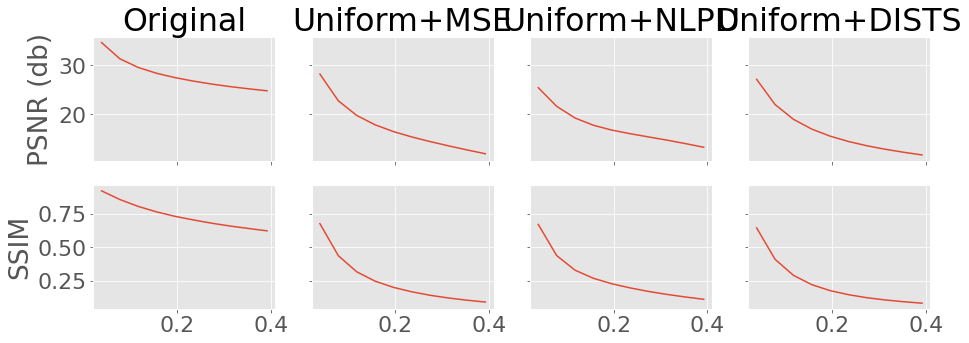

In [81]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey='row')
axs[0][0].plot(noise_levels, [i[0] for i in model_metrics])
axs[0][0].set_ylabel('PSNR (db)')
axs[0][1].plot(noise_levels, [i[0] for i in model_mse_metrics])
axs[0][2].plot(noise_levels, [i[0] for i in model_nlpd_metrics])
axs[0][3].plot(noise_levels, [i[0] for i in model_dists_metrics])

axs[1][0].plot(noise_levels, [i[1] for i in model_metrics])
axs[1][0].set_ylabel('SSIM')
axs[1][1].plot(noise_levels, [i[1] for i in model_mse_metrics])
axs[1][2].plot(noise_levels, [i[1] for i in model_nlpd_metrics])
axs[1][3].plot(noise_levels, [i[1] for i in model_dists_metrics])

axs[0][0].set_title('Original')
axs[0][1].set_title('Uniform+MSE')
axs[0][2].set_title('Uniform+NLPD')
axs[0][3].set_title('Uniform+DISTS')
plt.savefig('eval.png', bbox_inches='tight')

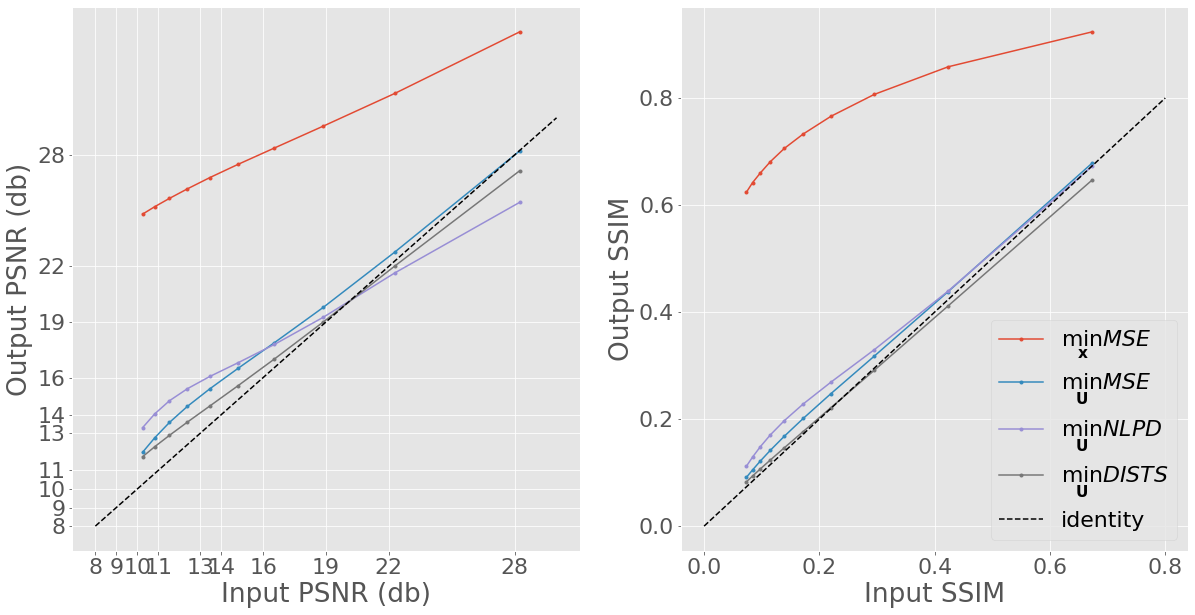

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(psnr_inputs, [i[0] for i in model_metrics], marker='.', label=r'$\min_{\mathbf{x}} MSE$')
axs[0].plot(psnr_inputs, [i[0] for i in model_mse_metrics], marker='.', label=r'$\min_{\mathbf{U}} MSE$')
axs[0].plot(psnr_inputs, [i[0] for i in model_nlpd_metrics], marker='.', label=r'$\min_{\mathbf{U}} NLPD$')
axs[0].plot(psnr_inputs, [i[0] for i in model_dists_metrics], marker='.', label=r'$\min_{\mathbf{U}} DISTS$')
axs[0].plot([8,30],[8,30] ,'k--', alpha = 1, label = 'identity')
axs[0].set_yticks([8, 9, 10, 11, 13, 14, 16, 19, 22, 28])
axs[0].set_xticks([8, 9, 10, 11, 13, 14, 16, 19, 22, 28])
axs[0].set_xlabel('Input PSNR (db)')
axs[0].set_ylabel('Output PSNR (db)')

axs[1].plot(ssim_inputs, [i[1] for i in model_metrics], marker='.', label=r'$\min_{\mathbf{x}} MSE$')
axs[1].plot(ssim_inputs, [i[1] for i in model_mse_metrics], marker='.', label=r'$\min_{\mathbf{U}} MSE$')
axs[1].plot(ssim_inputs, [i[1] for i in model_nlpd_metrics], marker='.', label=r'$\min_{\mathbf{U}} NLPD$')
axs[1].plot(ssim_inputs, [i[1] for i in model_dists_metrics], marker='.', label=r'$\min_{\mathbf{U}} DISTS$')
axs[1].plot([0,.8],[0,.8] ,'k--', alpha = 1, label = 'identity')
axs[1].set_xlabel('Input SSIM')
axs[1].set_ylabel('Output SSIM')
plt.legend(loc='lower right')
plt.savefig('eval_input_output.png', bbox_inches='tight')

-------- total number of iterations,  46
-------- average time per iteration (s),  0.0132
-------- total number of iterations,  46
-------- average time per iteration (s),  0.0076
-------- total number of iterations,  43
-------- average time per iteration (s),  0.009
-------- total number of iterations,  46
-------- average time per iteration (s),  0.0076
-------- total number of iterations,  44
-------- average time per iteration (s),  0.0079
-------- total number of iterations,  46
-------- average time per iteration (s),  0.0086
-------- total number of iterations,  46
-------- average time per iteration (s),  0.0088
-------- total number of iterations,  45
-------- average time per iteration (s),  0.0076


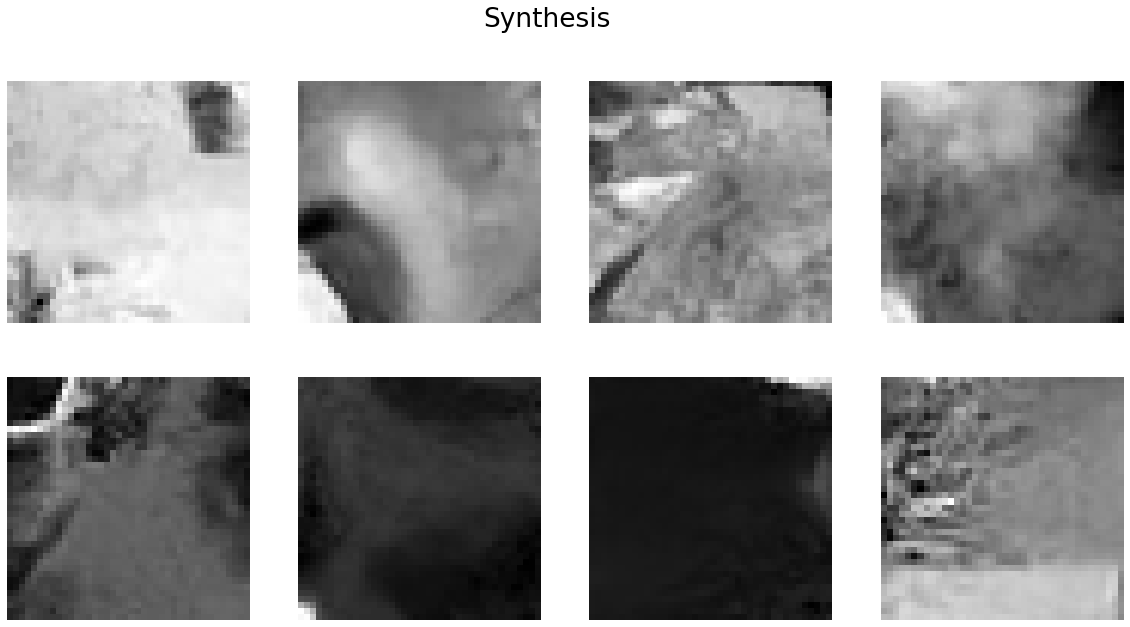

In [84]:
from Utils_inverse_prob import *
from algorithm_inv_prob import *

patch_size = (1,40,40)
x_c = torch.zeros(patch_size) 
synth = synthesis()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sample, interm_Ys = univ_inv_sol(model, 
                                     x_c = x_c, 
                                     task = synth,
                                     sig_0 = 1,
                                     sig_L = 0.01, 
                                     h0 = 0.01, 
                                     beta = 0.5,  # change beta to see how quality of generated samples change       
                                     freq = 0)
    sample = sample.permute(1,2,0).detach().numpy()
    axs[i//4][i%4].imshow(sample.squeeze(-1), cmap='gray')
    axs[i//4][i%4].set_axis_off()
plt.suptitle('Synthesis')
plt.savefig('sythnesis.png', bbox_inches='tight')

-------- total number of iterations,  31
-------- average time per iteration (s),  0.0071
-------- total number of iterations,  32
-------- average time per iteration (s),  0.0093
-------- total number of iterations,  32
-------- average time per iteration (s),  0.0106
-------- total number of iterations,  31
-------- average time per iteration (s),  0.008
-------- total number of iterations,  32
-------- average time per iteration (s),  0.0075
-------- total number of iterations,  32
-------- average time per iteration (s),  0.008
-------- total number of iterations,  31
-------- average time per iteration (s),  0.0073
-------- total number of iterations,  32
-------- average time per iteration (s),  0.0077


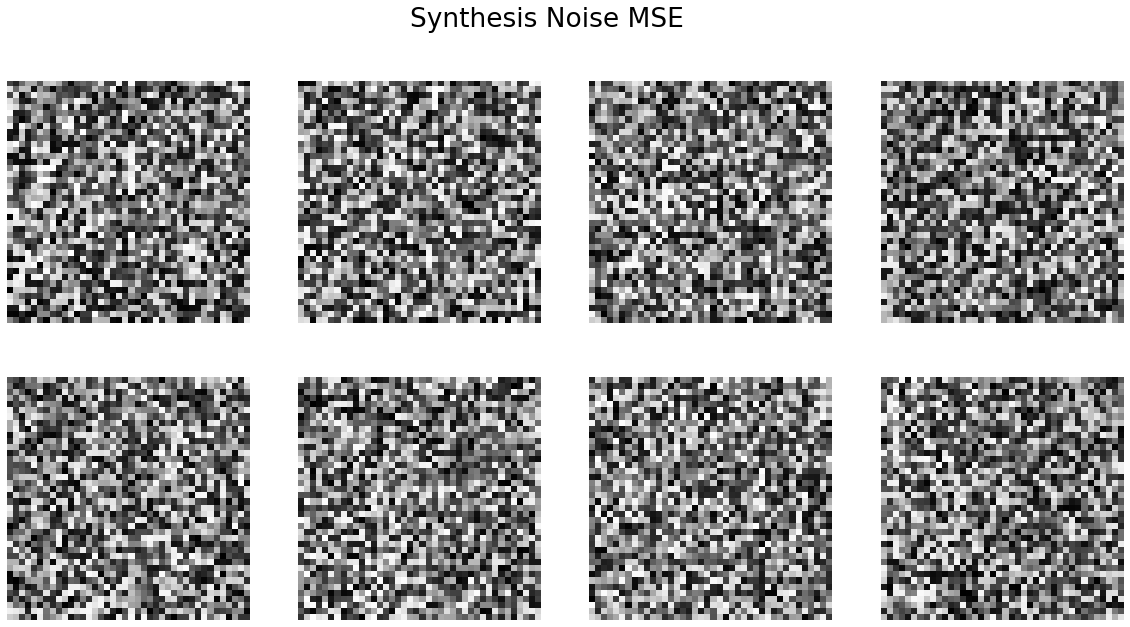

In [85]:
x_c = torch.zeros(patch_size)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sample, interm_Ys = univ_inv_sol(model_mse, 
                                     x_c = x_c, 
                                     task = synth,
                                     sig_0 = 1,
                                     sig_L = 0.01, 
                                     h0 = 0.01, 
                                     beta = 0.5,  # change beta to see how quality of generated samples change       
                                     freq = 0)
    sample = sample.permute(1,2,0).detach().numpy()
    axs[i//4][i%4].imshow(sample.squeeze(-1), cmap='gray')
    axs[i//4][i%4].set_axis_off()
plt.suptitle('Synthesis Noise MSE')
plt.savefig('sythnesis_mse.png', bbox_inches='tight')

-------- total number of iterations,  87
-------- average time per iteration (s),  0.0085
-------- total number of iterations,  85
-------- average time per iteration (s),  0.0099
-------- total number of iterations,  84
-------- average time per iteration (s),  0.0077
-------- total number of iterations,  86
-------- average time per iteration (s),  0.0117
-------- total number of iterations,  87
-------- average time per iteration (s),  0.0077
-------- total number of iterations,  85
-------- average time per iteration (s),  0.0076
-------- total number of iterations,  85
-------- average time per iteration (s),  0.0078
-------- total number of iterations,  87
-------- average time per iteration (s),  0.0073


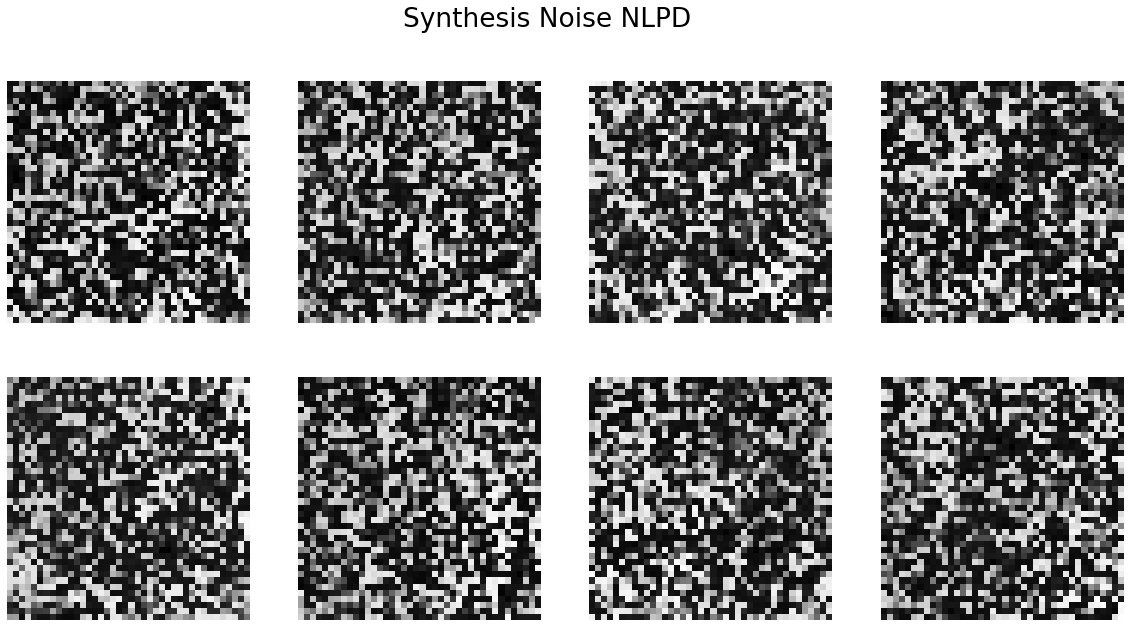

In [86]:
x_c = torch.zeros(patch_size)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sample, interm_Ys = univ_inv_sol(model_nlpd, 
                                     x_c = x_c, 
                                     task = synth,
                                     sig_0 = 1.,
                                     sig_L = 0.01, 
                                     h0 = 0.01, 
                                     beta = 0.5,  # change beta to see how quality of generated samples change       
                                     freq = 0)
    sample = sample.permute(1,2,0).detach().numpy()
    axs[i//4][i%4].imshow(sample.squeeze(-1), cmap='gray')
    axs[i//4][i%4].set_axis_off()
plt.suptitle('Synthesis Noise NLPD')
plt.savefig('sythnesis_nlpd.png', bbox_inches='tight')

-------- total number of iterations,  33
-------- average time per iteration (s),  0.008
-------- total number of iterations,  34
-------- average time per iteration (s),  0.0099
-------- total number of iterations,  33
-------- average time per iteration (s),  0.0103
-------- total number of iterations,  34
-------- average time per iteration (s),  0.0094
-------- total number of iterations,  33
-------- average time per iteration (s),  0.0075
-------- total number of iterations,  34
-------- average time per iteration (s),  0.008
-------- total number of iterations,  34
-------- average time per iteration (s),  0.0073
-------- total number of iterations,  34
-------- average time per iteration (s),  0.0073


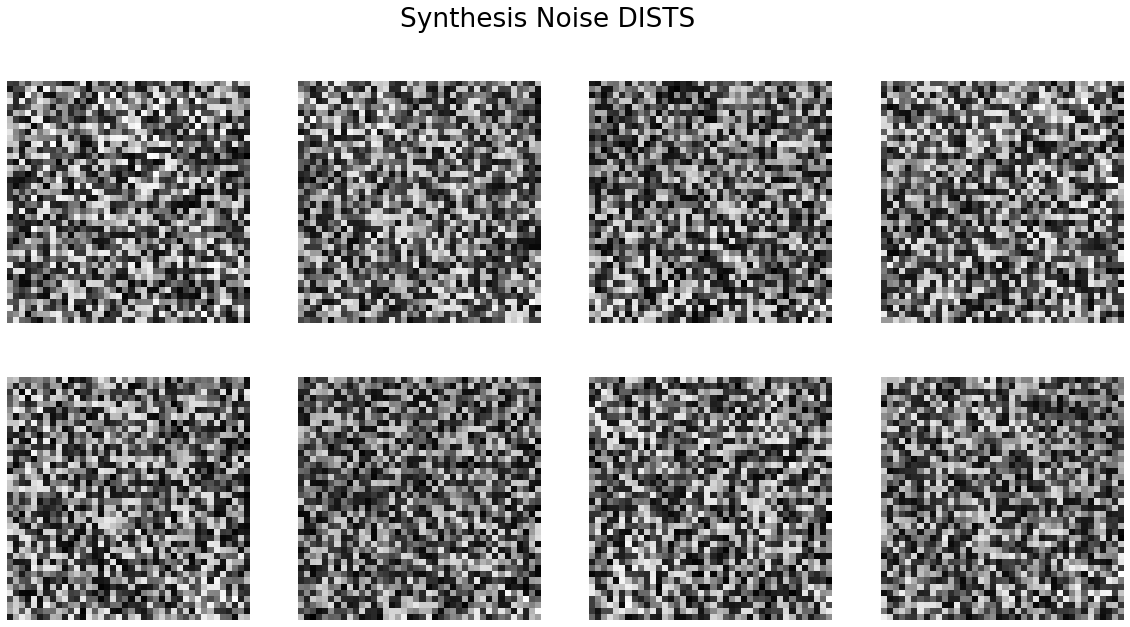

In [87]:
x_c = torch.zeros(patch_size)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sample, interm_Ys = univ_inv_sol(model_dists, 
                                     x_c = x_c, 
                                     task = synth,
                                     sig_0 = 1.,
                                     sig_L = 0.01, 
                                     h0 = 0.01, 
                                     beta = 0.5,  # change beta to see how quality of generated samples change       
                                     freq = 0)
    sample = sample.permute(1,2,0).detach().numpy()
    axs[i//4][i%4].imshow(sample.squeeze(-1), cmap='gray')
    axs[i//4][i%4].set_axis_off()
plt.suptitle('Synthesis Noise DISTS')
plt.savefig('sythnesis_dists.png', bbox_inches='tight')